## Setup

In [2]:
import os
import sys

import numpy as np
import pandas as pd

import paths
import pickle
import importlib

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [3]:
# A helper function to add lags to the input dataset
def add_lags_inputs(inputs, num_months_lags):
    inputs = inputs.copy(deep = True)
    
    for field in inputs:
        #for i in range(min(1, num_months_lag + 1), max(1, num_months_lag+1)):
        for i in num_months_lags:
                inputs[f'{field}_lag{i}'] = inputs[field].shift(time = i)

    return inputs

In [4]:
# A helper function to format RAPID in the same way as the other output streamfunctions for training
def format_RAPID(RAPID_path):
    
    PSI_RAPID = xr.open_dataset(RAPID_path)

    PSI_RAPID['depth'] = - PSI_RAPID['depth']
    PSI_RAPID = (PSI_RAPID
                 .rename({'depth': 'Z'})
                 .rename_vars({'stream_function_mar': 'psi_moc'})
                 .assign_coords(k=('k', np.arange(len(PSI_RAPID.depth.values)))))

    PSI_RAPID['psi_moc'] = (('k', 'time'), PSI_RAPID['psi_moc'].values)
    PSI_RAPID['psi_moc'] = PSI_RAPID['psi_moc'].expand_dims({'latitude': [26.5], 'longitude': [0.0]})
    return PSI_RAPID

In [5]:
# A helper function to extract the streamfunction at the level (depth or density) where the moc is maximal in a southern (max) or northern direction (min)
def get_PSI_at_max_density_level(PSI, moc_param="psi_moc", max=True):
    PSI_mean = PSI[moc_param].mean("time")  # np.abs()
    if max is True:
        max_index = PSI_mean.argmax(dim="k")
    else:
        max_index = PSI_mean.argmin(dim="k")
    return PSI.isel(k=max_index)

In [8]:
# A helper function to format the input files based on a given latitude
def format_lat_lon(value):
    """Format latitude or longitude with N/S or E/W suffix."""
    if value < 0:
        return f"{abs(value)}S"
    else:
        return f"{value}N"

In [58]:
# A wrapper class for stats models lin reg to facilitate sklearn grid search
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0.1, L1_wt=0.1):
        self.alpha = alpha
        self.L1_wt = L1_wt
        self.model = None

    def fit(self, X, y):
        self.model = sm.OLS(y, X).fit_regularized(alpha=self.alpha, L1_wt=self.L1_wt)
        return self

    def predict(self, X):
        return self.model.predict(X)

## Experiment variables

In [224]:
data_home = paths.LOCAL_DIR

# We are specifically interested in the atlantic mask at 30S 
lat = -30
atlantic_lon_min = -50
atlantic_lon_max = 17

RAPID_path = os.path.join(paths.RAPID_ARRAY, "moc_vertical.nc")
strf_path = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_atlantic_sf_depth.pickle"
depth_path = f"{data_home}/ecco_data_minimal/depth_range.pickle"

# MISCELLANEOUS (for Linear Regression)
verbose = True
mape_thresh = 0.5
cross_val_folds = 4
param_grid_levels = 2

## Loading and preprocessing relevant data

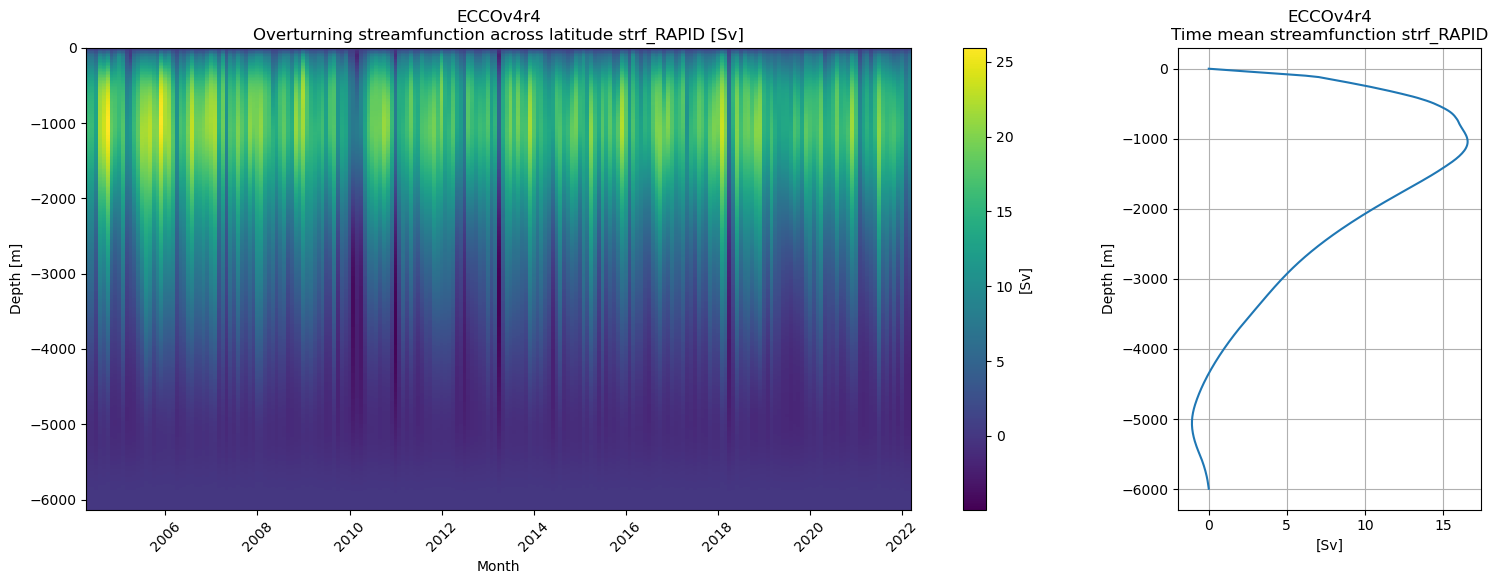

In [225]:
# Prepare the input RAPID streamfunction and resample to monthly mean values
PSI_RAPID = format_RAPID(RAPID_path).resample(time='1ME').mean()

RAPID_inputs = get_PSI_at_max_density_level(
                    PSI_RAPID, moc_param='psi_moc', max=True
                ).drop_vars('Z')
RAPID_all_inputs = add_lags_inputs(RAPID_inputs, [4,6,12,24,48])    

plot_depth_stf_vs_time(stf_ds=PSI_RAPID.squeeze(), label='strf_RAPID', param='psi_moc')

In [226]:
# Prepare the input surface variables at 30S and clip them according to the atlantic basin mask
inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}.nc").isel(latitude=slice(1,2))
inputs = inputs.sel(longitude=slice(atlantic_lon_min, atlantic_lon_max))
inputs

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 1, longitude: 134)
Coordinates:
  * latitude   (latitude) float32 -29.75
  * longitude  (longitude) float32 -49.75 -49.25 -48.75 ... 15.75 16.25 16.75
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 ...
    ZWS        (time, latitude, longitude) float32 ...
    OBP        (time, latitude, longitude) float32 ...
    SSS        (time, latitude, longitude) float32 ...
    SST        (time, latitude, longitude) float32 ...

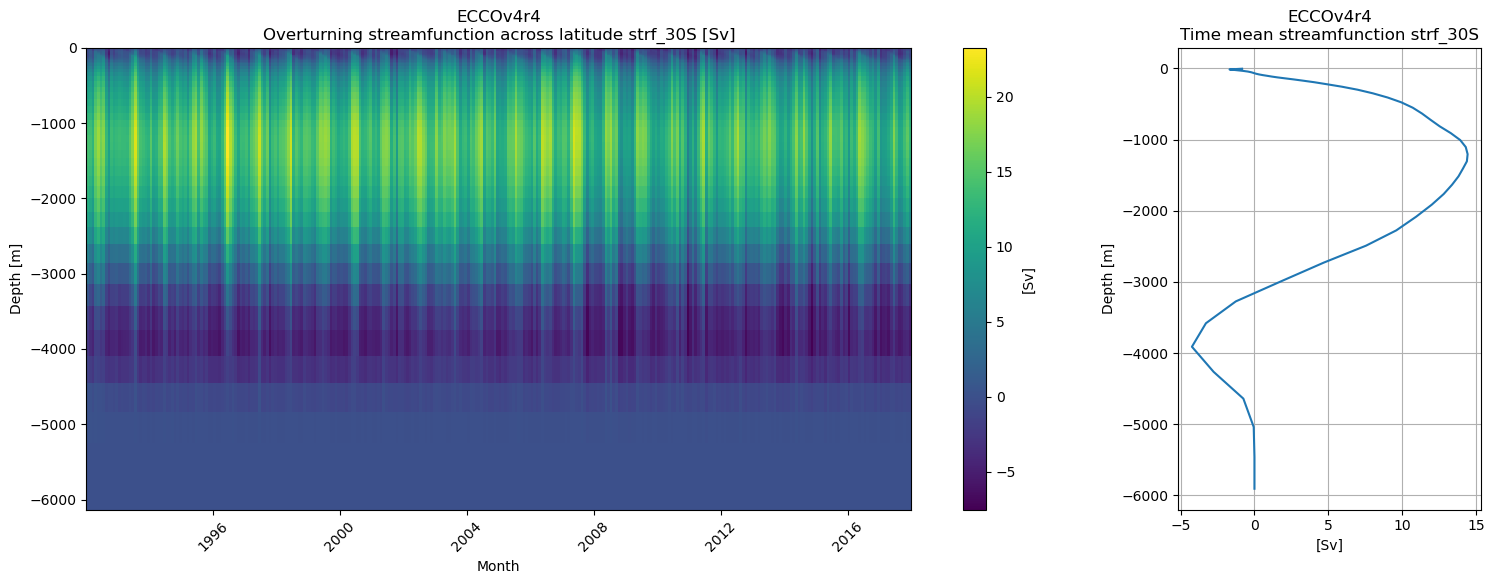

In [227]:
# Retrieve the output 30S streamfunction and calculate the moc strenght in the upper and lower cell
with open(strf_path, 'rb') as f:
    strf = pickle.load(f).astype(np.float64)[::-1] #Invert the depth values

strf = np.expand_dims(strf[:, 1, :], 1) # grabbing just 30S
strf = np.transpose(strf, (2,0,1))
    
strf = xr.Dataset(
        data_vars = {'moc' : (["time", "k", "latitude"], strf)}, 
        coords = {'time' : inputs.time,  'k': np.arange(50), 'latitude' : np.atleast_1d(-60)}
        )
ECCO_GRID = xr.open_dataset(paths.geom_fp)
strf = strf.assign_coords(Z=('k', ECCO_GRID.coords['Z'].data))

outputs_upper_cell = get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=True)
outputs_bottom_cell = get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=False)

plot_depth_stf_vs_time(stf_ds=strf.squeeze(), label='strf_30S', param='moc')

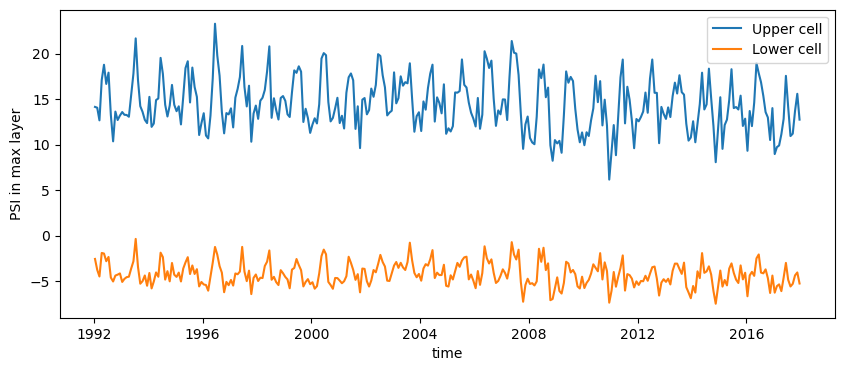

In [228]:
# Plot both streamfunctions for a sanity check
plt.figure(figsize = (10, 4))
plt.plot(outputs_upper_cell["time"].squeeze(), outputs_upper_cell["moc"].squeeze(), label='Upper cell')   
plt.plot(outputs_bottom_cell["time"].squeeze(), outputs_bottom_cell["moc"].squeeze(), label='Lower cell') 
plt.xlabel('time')
plt.ylabel('PSI in max layer')
plt.legend()

In [237]:
# Decide which covariates and output to use 
outputs = outputs_bottom_cell

psi_moc_variable = "psi_moc_lag48"                   #Can be normal 'psi_moc' or any other lag defined above
RAPID_inputs = RAPID_all_inputs[[psi_moc_variable]]

In [238]:
# RAPID has the latest start date and the ECCO data has the earliest end date (combine)
date_range = (RAPID_inputs.dropna(dim='time', how='any').time.values[0], inputs.time.values[-1]) 
date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
print('Date range to align to:', date_range)

# Align the surface variable inputs with RAPID, then align the in- and outputs
inputs, RAPID_inputs = align_inputs_outputs(inputs, RAPID_inputs, date_range = date_range, ecco=False)
inputs, outputs = align_inputs_outputs(inputs, outputs, date_range = date_range, ecco=False)

Date range to align to: ('2008-04-30', '2017-12-16')


In [244]:
# Preprocess both surface variables as the RAPID input data
pp_data_RAPID = apply_preprocessing(RAPID_inputs,
                                    mode="inputs",
                                    remove_season=False,
                                    remove_trend=False,
                                    standardize=True,
                                    lowpass=False)

pp_data_surface = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=False,
                              remove_trend=False,
                              standardize=True,
                              lowpass=False)

# reshape as desired and convert to a numpy array
pp_data_RAPID_np = reshape_inputs(pp_data_RAPID, keep_coords=["time"], data_vars=[psi_moc_variable])
pp_data_SURFACE_np = reshape_inputs(pp_data_surface, keep_coords=["time"], data_vars=["SSH", "SST", "SSS", "OBP", "ZWS"])

# Concatenate the different information layers together or keep only one
pp_data_np = np.concatenate((pp_data_RAPID_np, pp_data_SURFACE_np), axis=-1)
#pp_data_np = pp_data_SURFACE_np

axes: ['time', 'feature']
variables: ['psi_moc_lag48']
shape: (116, 1)
axes: ['time', 'feature']
variables: ['ZWS']
shape: (116, 1)


In [245]:
# MOC strength preprocessing
strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=False,
                               remove_trend=False,
                               standardize=False,
                               lowpass=False)
strength_np = strength.moc.squeeze().values

X = pp_data_np
y = strength_np[-X.shape[0]:]

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)


Inputs shape: (116, 2)
Outputs shape: (116,)


In [246]:
# add bias term for linear regression
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, stratify=None, random_state=123456)

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


## Running Linear Regression

In [247]:
# hyperparameters to optimise
param_grid = {
    "alpha": np.logspace(-4, 4, 10),
    "L1_wt": np.linspace(0, 1, 10)
}

# grid search - 10-fold cross-validation
grid_search = GridSearchCV(SMWrapper(), param_grid, cv=10, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# report best result
print(f"Best MSE (cross-validation): {round(-grid_search.best_score_, 3)}")

#  calculate test performance and optionally report
y_pred = grid_search.best_estimator_.predict(X_test)
y_pred_train = grid_search.best_estimator_.predict(X_train)
metric_dict = {}
    
metric_dict['R^2'] = round(r2_score(y_test, y_pred), 3)
metric_dict['MSE'] = round(mean_squared_error(y_test, y_pred), 3)
metric_dict['RMSE'] = round(root_mean_squared_error(y_test, y_pred), 3)
metric_dict['MAE'] = round(mean_absolute_error(y_test, y_pred), 3)
metric_dict['MAPE'] = round(mean_absolute_percentage_error(y_test, y_pred) * 100, 3)
metric_dict['train_corr'] = round(np.corrcoef(np.array(y_pred_train).squeeze(), y_train)[0, 1], 3)
metric_dict['test_corr'] = round(np.corrcoef(np.array(y_pred).squeeze(), y_test)[0, 1], 3)

#  calculating custom MAPE to ignore the smallest observed MOC values
mape, num_discard = custom_MAPE(y_test, y_pred, threshold = mape_thresh, return_num_discarded = True)
pct_kept = round((len(y_test) - num_discard) / len(y_test) * 100, 3)
metric_dict['MAPE_thresh'] = f'{round(mape * 100, 3)} (thresh={mape_thresh}, {pct_kept}% kept)'

if verbose:
    metrics_series = pd.Series(metric_dict)
    metrics_df = metrics_series.to_frame(name='Value')

Best MSE (cross-validation): 0.771


## Output visualisation

,Value
R^2,0.541
MSE,0.513
RMSE,0.716
MAE,0.594
MAPE,14.91
train_corr,0.78
test_corr,0.74
MAPE_thresh,"14.91 (thresh=0.5, 100.0% kept)"


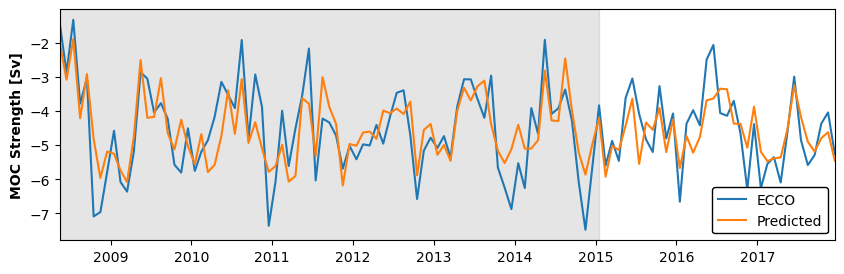

In [248]:
# Extracting all predictions in time order
train_set_pred = grid_search.best_estimator_.predict(X_train)
test_set_pred = grid_search.best_estimator_.predict(X_test)
all_preds = np.concatenate([train_set_pred, test_set_pred])

time = outputs.time.values

display(metrics_df)

fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

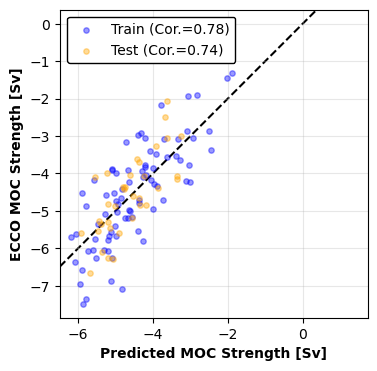

In [249]:
# Alternate view: looking at a scatterplot of predicted vs. actual
fig, ax = pred_vs_actual(train_set_pred, test_set_pred, y_train, y_test)
plt.show()